# <center> Anomaly detection </center>

<img src="http://www.bigdata-alliance.org/wp-content/uploads/2016/12/anomaly.jpg" height="600" width="600">


In [1]:
import json
import sys
sys.path.append('/Users/dmitrys/anaconda2/lib/python2.7/site-packages')
import requests as r

import pandas as pd
import numpy as np
import yaml
import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


%matplotlib inline
import warnings
warnings.filterwarnings('ignore') 

## Данные по часовому онлайну игроков

In [5]:
to_date = datetime.datetime.today().strftime("%Y-%m-%d")
#DAU_hour = downloadMixpanel("LAUNCH_SESSION_START", "os", unit="hour")
DAU_hour = pd.read_csv('DAU_hour.csv')

In [6]:
DAU_hour.head()

,amazon,android,iphone,windows,winphone
2017-02-01 00:00:00,310,28070,10049,1585,1795
2017-02-01 01:00:00,197,29242,9870,1737,1836
2017-02-01 02:00:00,272,32845,10728,1744,2002
2017-02-01 03:00:00,542,40524,13524,2217,2334
2017-02-01 04:00:00,850,47643,16659,2681,2778


---
# Moving Averages

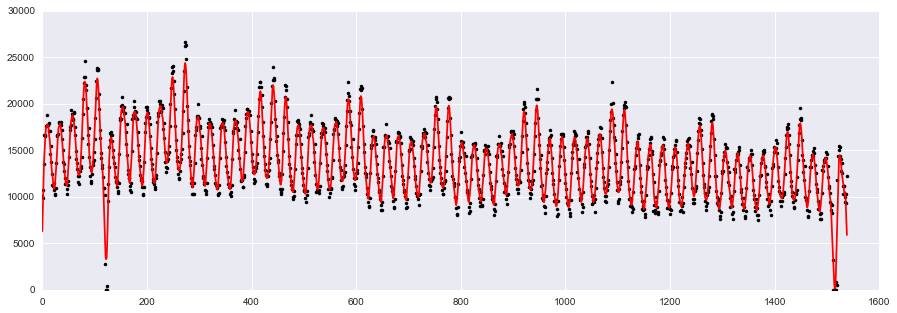

In [17]:
from __future__ import division
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid, figure
from numpy import linspace, loadtxt, ones, convolve
import numpy as numpy


data = DAU_hour.iphone
data = data.loc[data.index[0]:data.index[data.nonzero()[0][-1]]]
x = data.index
y = data.values


def movingaverage(interval, window_size):
    window = numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')

figure(figsize=(15, 5))
plot(y,"k.")
y_av = movingaverage(y, 7)
plot(y_av,"r")
grid(True)
show()

In [10]:
def moving_average(series, n):
    return np.average(series[-n:])

In [11]:
moving_average(y, 4)

10311.0

In [12]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

In [13]:
weighted_average(y, [0.1, 0.4, 0.7, 0.9])

22839.899999999998

In [14]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

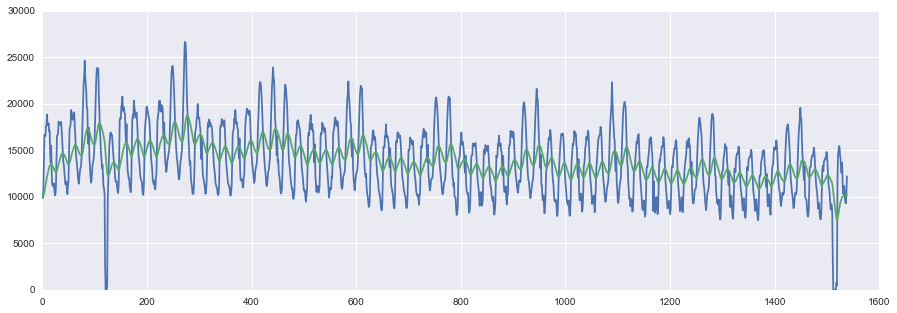

In [16]:
figure(figsize=(15, 5))
plt.plot(y)
plt.plot(exponential_smoothing(y, 0.05));

# Window estimations

In [18]:
def plotAnomalies(period, interval):
    
    """
    period - seasonal component
    interval - prediction interval width
    
    """
    
    MOV = movingaverage(y,period).tolist()[period:-period]
    STD = np.std(MOV)
    events = [np.NaN] * len(y[period:-period])
    
    for i in range(len(y[period:-period])):
        if y[period:-period][i] < MOV[i]-interval*STD:
            events[i] = y[period:-period][i]


    plt.figure(figsize=(15, 5))
    plot(y[period:-period])
    plot(MOV)
    plot(MOV+interval*STD, 'r--')
    plot(MOV-interval*STD, 'r--')
    plot(events, "o", markersize=10)
    grid(True)

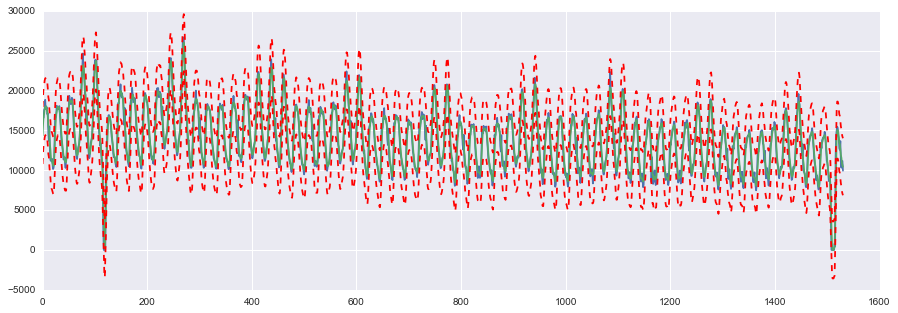

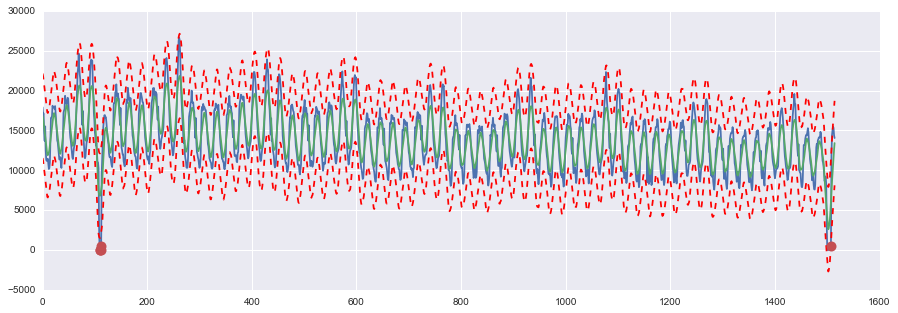

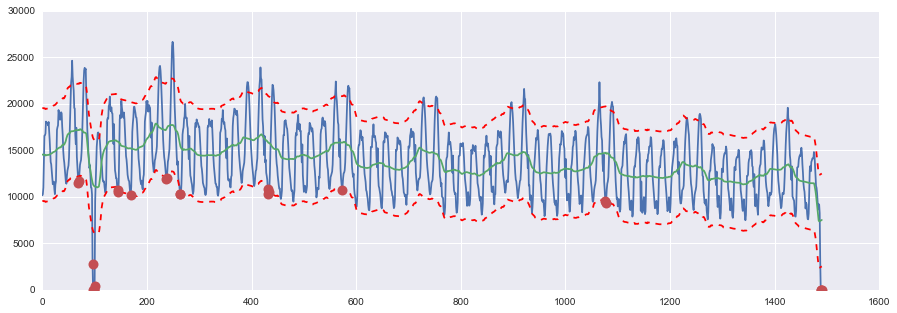

In [19]:
plotAnomalies(period=4, interval=1)
plotAnomalies(period=12, interval=1.96)
plotAnomalies(period=24, interval=3)

---
# Exponential Smoothing

[Holt-Winters Forecasting for Dummies ](https://grisha.org/blog/2016/02/17/triple-exponential-smoothing-forecasting-part-iii/)

In [20]:
def exponentialSmooth(alpha=0.05, beta=0.001, std_window=2, halflife=4):
    N = len(y)
    smoothed_val = np.zeros((N, ))
    prediction = np.zeros((N,))


    smoothed_val[0] = y[0]
    smoothed_slope = np.zeros((N,))
    prediction[0] = y[0]

    for i in range(1, N):
        smoothed_val[i] = (alpha * y[i] + 
                          (1 - alpha) * smoothed_val[i-1] + smoothed_slope[i-1])

        smoothed_slope[i] = (beta * (smoothed_val[i] - smoothed_val[i-1]) + 
                            (1-beta) * smoothed_slope[i-1])

        prediction[i] = smoothed_val[i-1] + smoothed_slope[i-1]



    smoothed_std_ts = pd.Series(
        pd.ewma(np.sqrt((y-prediction)**2), halflife=halflife),
        name="smoothed_std").shift(1)
    
    results = pd.DataFrame(y+res.seasonal, columns=["actual"])
    results["prediction"]=prediction+res.seasonal
    results["std_smooth"]=smoothed_std_ts
    results["lower"] = results.prediction - std_window * results.std_smooth
    results["up"] = results.prediction + std_window * results.std_smooth
    results["anomalies"] = [np.NaN]*N
    results["anomalies"][results.actual<results.lower] = results.actual[results.actual<results.lower]
    return results

In [21]:
def plotExponentialSmooth(alpha=0.05, beta=0.001, std_window=2, halflife=4):
    results = exponentialSmooth(alpha, beta, std_window, halflife)
    plt.figure(figsize=(25, 10))
    plot(results.actual)
    plot(results.prediction)
    plot(results.anomalies, "o", markersize=10)
    plot(results.up, "r--", alpha=0.5)
    plot(results.lower, "r--", alpha=0.5)
    grid(True)

In [22]:
from scipy import stats
import statsmodels.api as sm

Критерий Дики-Фуллера: p=0.005546


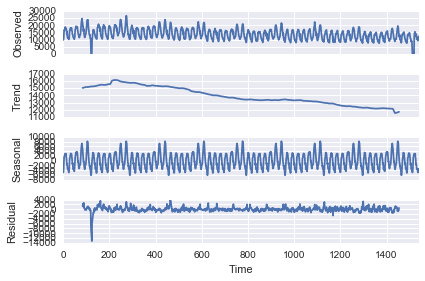

In [25]:
#figsize(15,7) 
res = sm.tsa.seasonal_decompose(y, freq=24*7) # так как есть и дневная, и недельная цикличность
res.plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

In [26]:
data = DAU_hour.android
data = data.loc[data.index[0]:data.index[data.nonzero()[0][-1]]]
x = data.index
y = data.values
y = y-res.seasonal

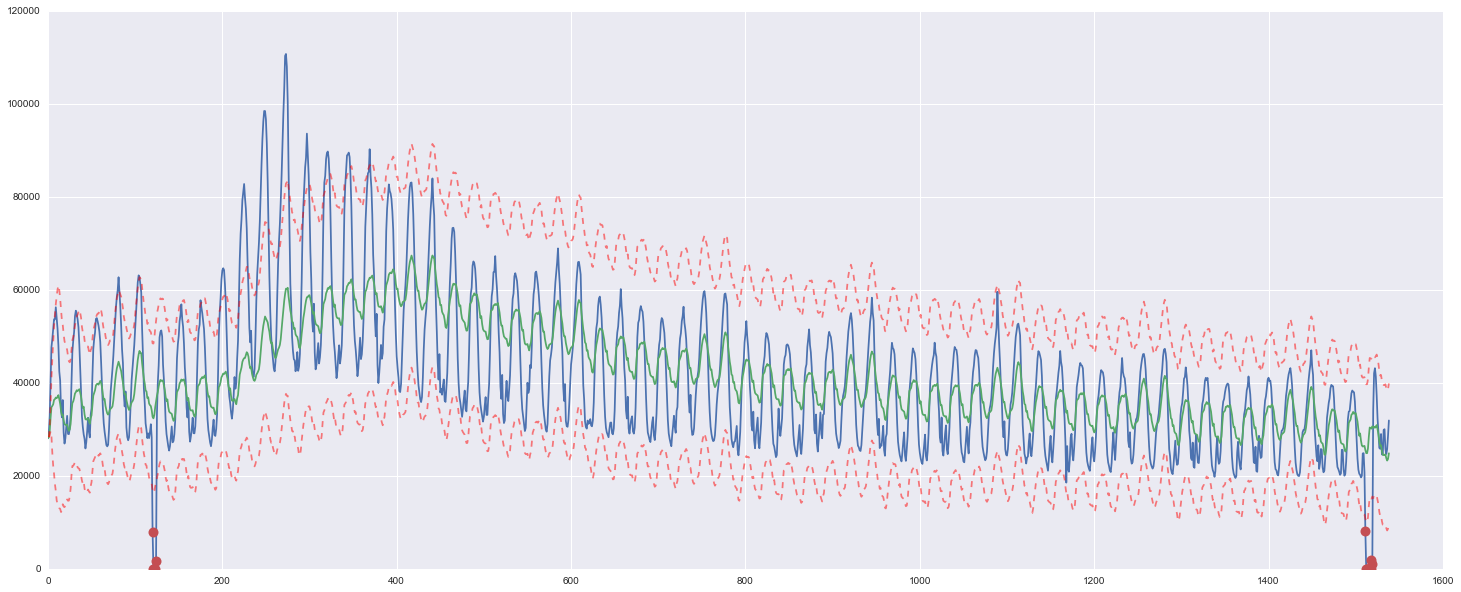

In [27]:
plotExponentialSmooth(alpha=0.01, beta=0.000001, std_window=2, halflife=1000)

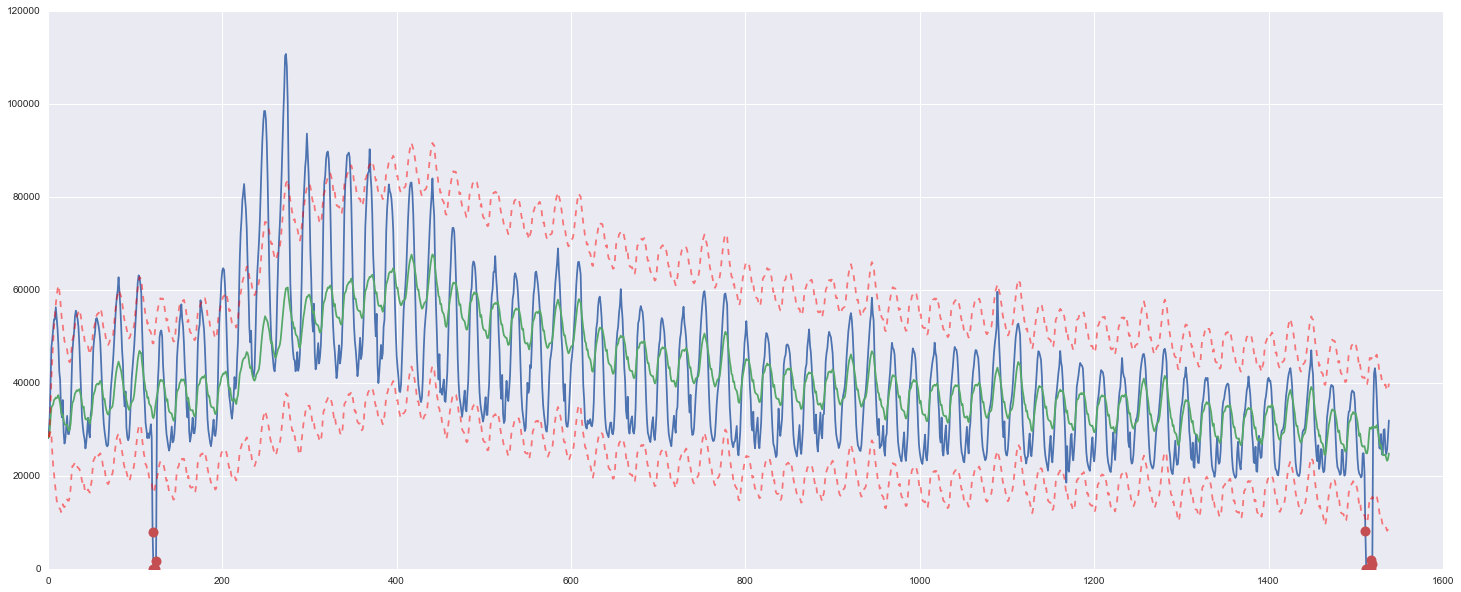

In [28]:
plotExponentialSmooth(alpha=0.01, beta=0.0001, std_window=2, halflife=1000)

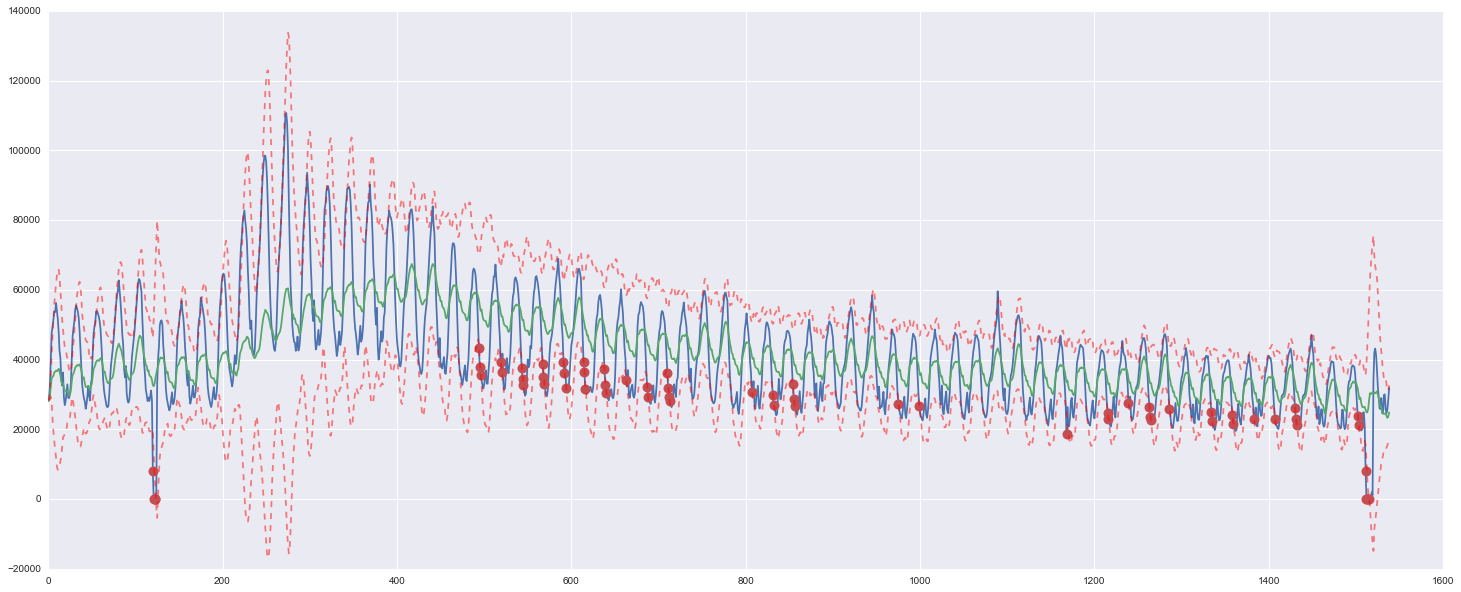

In [29]:
plotExponentialSmooth(alpha=0.01,beta=0.00001, std_window=1.96)

---
# Triple exponential Smoothing: Holt-Winters & Brutlag


[Implementation of Brutlag's algorithm in Anomaly Detection](https://fedcsis.org/proceedings/2012/pliks/118.pdf)

[How to calculate parameters](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm)

In [30]:
data = DAU_hour.iphone
data = data.loc[data.index[0]:data.index[data.nonzero()[0][-2]]]

In [31]:
#series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
#          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
#          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
#          18,8,17,21,31,34,44,38,31,30,26,32]

For double exponential smoothing we simply used the first two points for the initial trend. With seasonal data we can do better than that, since we can observe many seasons and can extrapolate a better starting trend. The most common practice is to compute the average of trend averages across seasons.

In [32]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

For initial seasonal components we need to compute the average level for every observed season we have, divide every observed value by the average for the season it’s in and finally average each of these numbers across our observed seasons

In [33]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
        
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

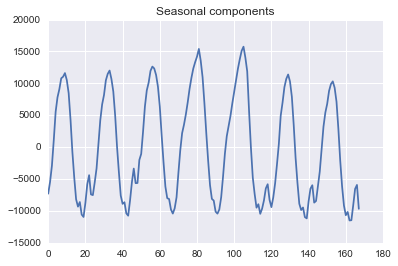

In [34]:
plt.plot(initial_seasonal_components(y, 24*7).values())
plt.title("Seasonal components");

In [35]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    
    return result

In [36]:
class tiripleExpSmooth_Brutlag:
    
    """
    Implementation of Brutlag's Algorithm in Anomaly Detection, based on Holt-Winters STL
    
    """
    
    def __init__(self,series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # compute season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # compute initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # initial values
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # we are forecasting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01)
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
                
                
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])
            
            
        

# Подбираем параметры на кросс-валидации
[Как кросс-валидироваться на временных рядах](http://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection)

In [46]:
def CV_model_error(initial_values):
    
    """
    Takes initial values of alpha, beta and gamma, fits it n_splits times to the data
    Returns average mean squared error of the folds
    
    """
    
    values = data.values
    alpha, beta, gamma = initial_values
    errors = []
    tscv = TimeSeriesSplit(n_splits=3) # n_splits - сколько фолдов
    
    for train, test in tscv.split(values):

        predictions = triple_exponential_smoothing(series=values[train], 
                                                    slen = 2, 
                                                    alpha=alpha, 
                                                    beta=beta, 
                                                    gamma=gamma, 
                                                    n_preds=len(test))[-len(test):]
        true = values[test]
        error = mean_squared_error(predictions, true)
        errors.append(error)
    return np.mean(np.array(errors))

## Подбираем параметры

In [54]:
initial_values = [np.random.random_sample() for x in range(3)] # рандомно инициализируем

# Минимизируем симплекс-методом нашу ошибку на кросс-валидации, при ограничениях на параметры
opt = minimize(CV_model_error, x0=initial_values, method='TNC', bounds = ((0, 1), (0, 1), (0, 1)))

print("Function result:", opt.fun)
print("Array:", opt.x)

('Function result:', 11610415.857475756)
('Array:', array([ 0.00260062,  0.1239129 ,  0.03156488]))


In [55]:
# [ 0.01326069,  0.00894875,  0.01076867]

In [56]:
alpha, beta, gamma = opt.x
alpha, beta, gamma

(0.0026006158031368076, 0.12391290199608418, 0.031564875276356485)

In [57]:
model = tiripleExpSmooth_Brutlag(series=data[:-128], 
                                 slen = 24*7, 
                                 alpha=alpha, 
                                 beta=beta, 
                                 gamma=gamma, 
                                 n_preds=128, 
                                 scaling_factor=2.58)
model.triple_exponential_smoothing()

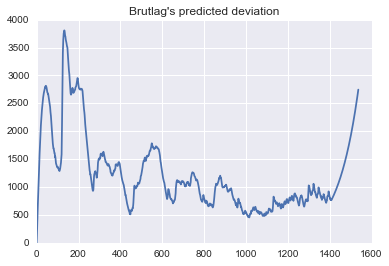

In [58]:
plt.plot(model.PredictedDeviation)
plt.title("Brutlag's predicted deviation");

In [59]:
def plotBrutlagAnomalies():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(15, 5))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plot(Anomalies, "o", markersize=10)
    plt.legend(loc="best", fontsize=13);

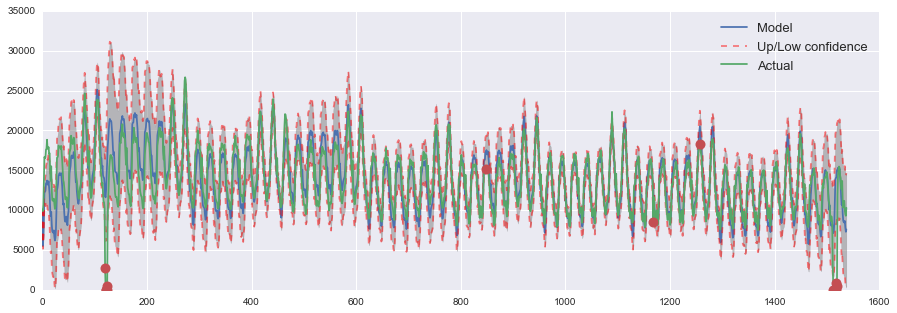

In [60]:
plotBrutlagAnomalies()

# Statistical testing

[Statistics for Monitoring: Anomaly Detection ](http://mabrek.github.io/blog/statistics-for-monitoring-anomaly-p2/)

In [61]:
from scipy.stats import ks_2samp

np.random.seed(42)
x = np.random.normal(0, 1, 1000)
y = np.random.normal(0, 1, 1000)
z = np.random.normal(1.1, 0.9, 1000)
 
ks_2samp(x, y)

Ks_2sampResult(statistic=0.044999999999999984, pvalue=0.25751117551495284)

In [62]:
def window_KS_Statistics(data, window_size=24):
    result = []
    for x in range(0, len(data), window_size):
        result.append(ks_2samp(data[0+x:24+x], data[24+x:48+x]).statistic)
    return result

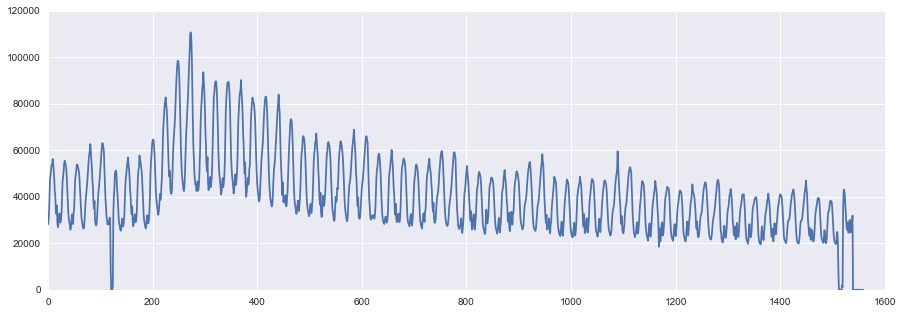

In [65]:
figure(figsize=(15, 5))
plt.plot(DAU_hour.android.values);

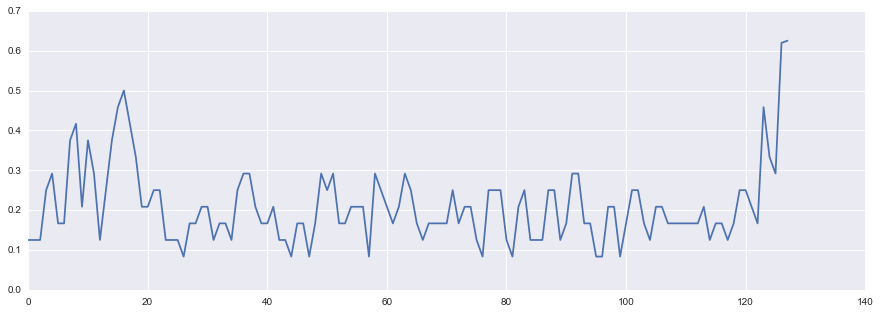

In [66]:
figure(figsize=(15, 5))
plt.plot(window_KS_Statistics(DAU_hour.android.values, window_size=12));

---
# SARIMA

[ARIMA in python](https://habrahabr.ru/post/207160/)

[SARIMA in python](https://habrahabr.ru/post/210530/)

In [829]:
from scipy import stats
%pylab inline
import statsmodels.api as sm

def plot_acf_pacf(data):
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(data.squeeze(), lags=48, ax=ax)
    pylab.show()
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(data.squeeze(), lags=48, ax=ax)
    pylab.show()

Populating the interactive namespace from numpy and matplotlib


Критерий Дики-Фуллера: p=0.029478


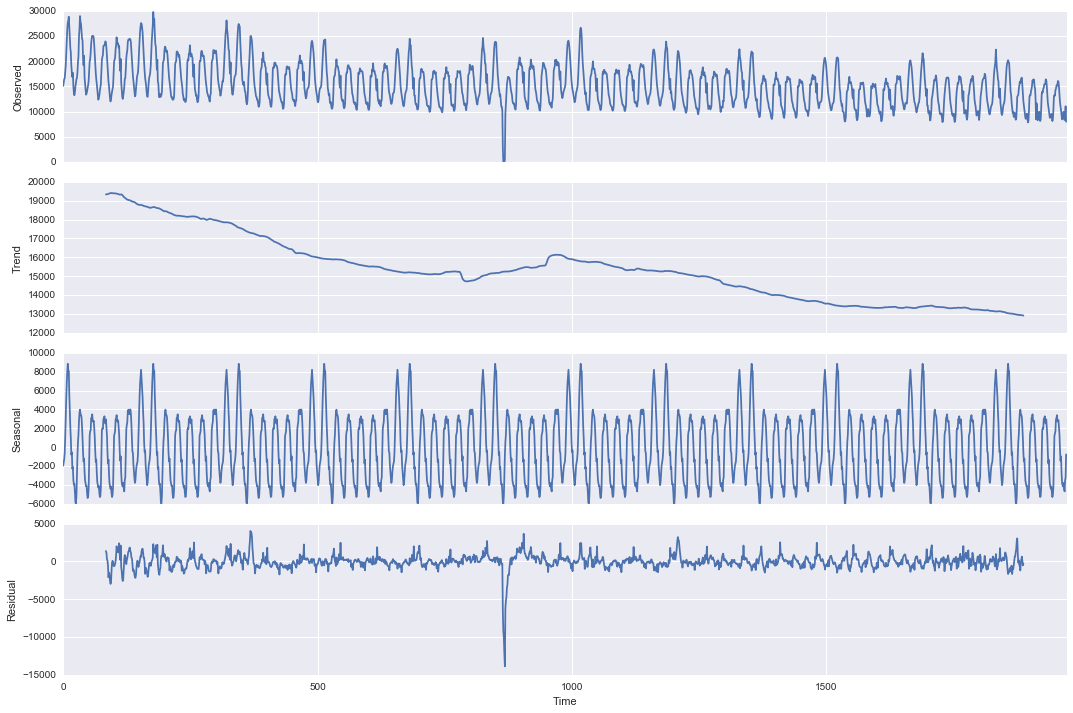

In [838]:
data = DAU_hour.iphone
data = data.loc[data.index[0]:data.index[data.nonzero()[0][-1]]]
x = data.index
y = data.values

figsize(15, 10)
res = sm.tsa.seasonal_decompose(y, freq=24*7) # так как есть и днейвная, и недельная цикличность
res.plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

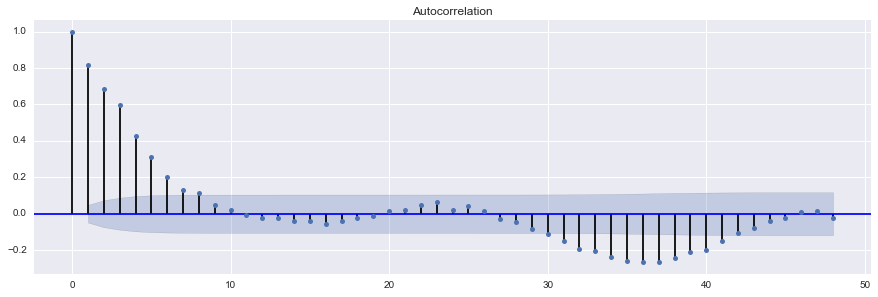

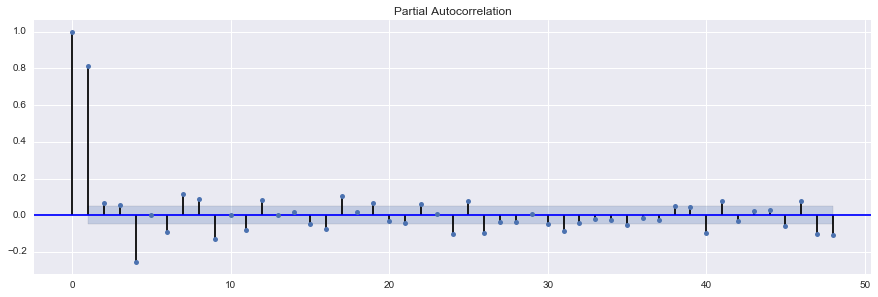

In [839]:
plot_acf_pacf(res.resid[24*7:-24*7])

In [848]:
ps = range(2, 4)
d=1
qs = range(2, 5)
Ps = range(3, 7)
D=1
Qs = range(0, 2)

In [849]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [850]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in parameters_list:
    print param
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        %time model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(2, 2, 3, 0)
(2, 2, 3, 1)
(2, 2, 4, 0)
(2, 2, 4, 1)
(2, 2, 5, 0)
(2, 2, 5, 1)
(2, 2, 6, 0)
(2, 2, 6, 1)
(2, 3, 3, 0)
CPU times: user 2.35 s, sys: 75 ms, total: 2.42 s
Wall time: 1.55 s
(2, 3, 3, 1)
CPU times: user 3.01 s, sys: 103 ms, total: 3.11 s
Wall time: 1.88 s
(2, 3, 4, 0)
CPU times: user 5.36 s, sys: 166 ms, total: 5.53 s
Wall time: 3.19 s
(2, 3, 4, 1)
CPU times: user 5.67 s, sys: 166 ms, total: 5.83 s
Wall time: 3.35 s
(2, 3, 5, 0)
CPU times: user 8.38 s, sys: 242 ms, total: 8.63 s
Wall time: 4.92 s
(2, 3, 5, 1)
CPU times: user 9 s, sys: 270 ms, total: 9.27 s
Wall time: 5.39 s
(2, 3, 6, 0)
CPU times: user 12.8 s, sys: 366 ms, total: 13.1 s
Wall time: 8.2 s
(2, 3, 6, 1)
CPU times: user 13.2 s, sys: 376 ms, total: 13.6 s
Wall time: 7.73 s
(2, 4, 3, 0)
CPU times: user 34.2 s, sys: 343 ms, total: 34.5 s
Wall time: 35.1 s
(2, 4, 3, 1)
CPU times: user 45.3 s, sys: 393 ms, total: 45.6 s
Wall time: 50.5 s
(2, 4, 4, 0)
CPU times: user 2min 19s, sys: 1.01 s, total: 2min 20s
Wall time: 1m

LinAlgError: Singular matrix

In [851]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
9   (2, 4, 3, 1)  33772.318886
12  (2, 4, 5, 0)  33778.894286
8   (2, 4, 3, 0)  33789.837558
10  (2, 4, 4, 0)  33791.050090
11  (2, 4, 4, 1)  33793.380386


In [852]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                 1972
Model:             SARIMAX(2, 1, 4)x(3, 1, 1, 7)   Log Likelihood              -16875.159
Date:                           Sat, 25 Mar 2017   AIC                          33772.319
Time:                                   13:08:52   BIC                          33833.774
Sample:                                        0   HQIC                         33794.900
                                          - 1972                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6860      0.281      2.443      0.015       0.136       1.236
ar.L2          0.1036      0.257      0.403

Критерий Стьюдента: p=0.296750
Критерий Дики-Фуллера: p=0.000001


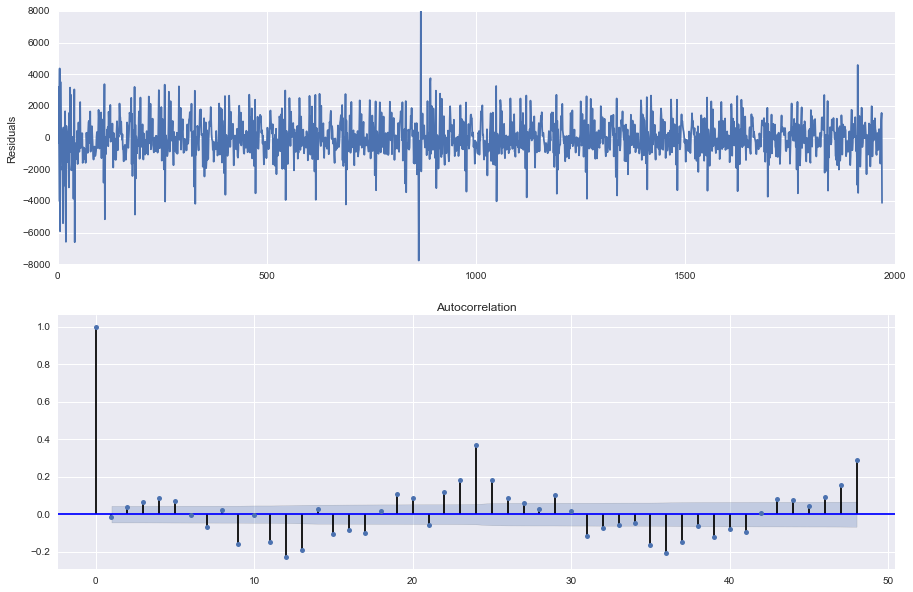

In [856]:
plt.subplot(211)
plt.plot(best_model.resid[1:])
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[1:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

In [859]:
l = [np.NaN] * len(y)
forecast = best_model.predict(start=len(y), end=(len(y)+48))
l.extend(forecast)

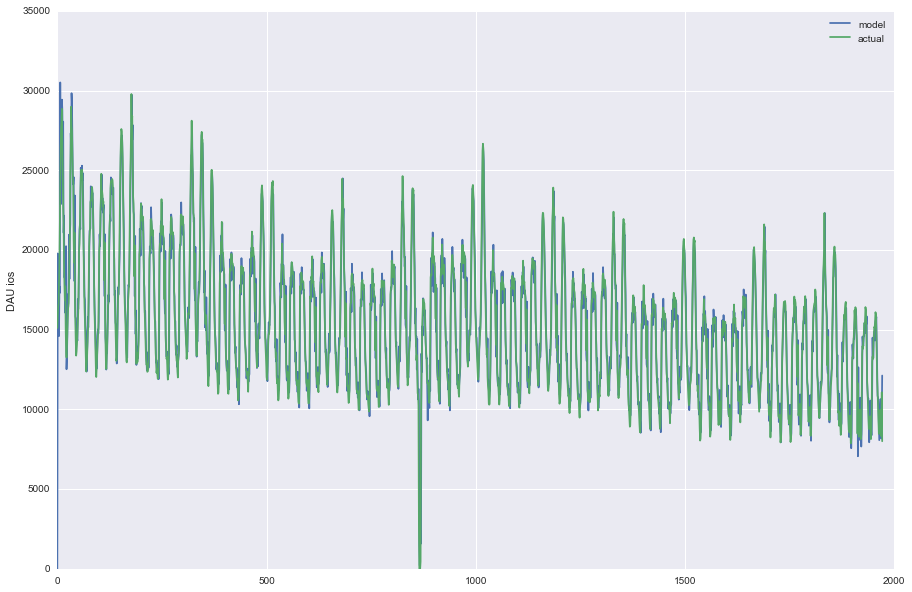

In [864]:
plt.plot(best_model.fittedvalues, label="model")
plt.plot(y, label="actual")
plt.ylabel('DAU ios')
plt.legend(loc=1)
pylab.show()

# OneClass SVM

[Time-series novelty detection using one-class SVM](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.653.2440&rep=rep1&type=pdf)

In [706]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

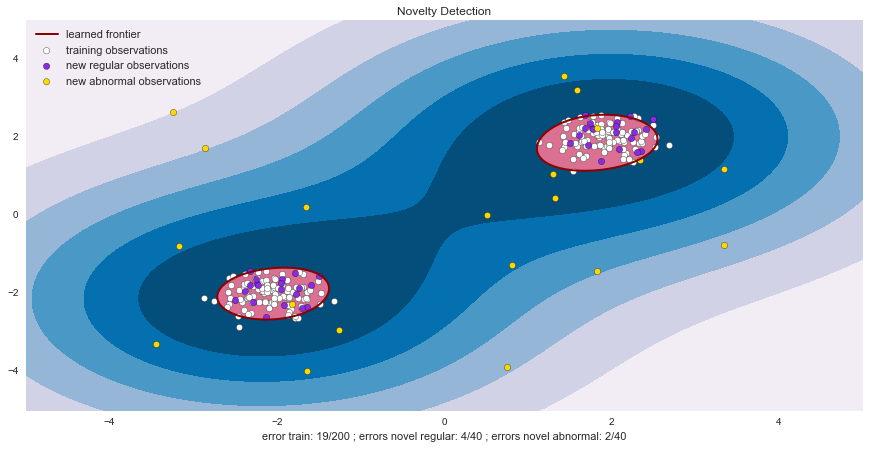

In [707]:
# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s)
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

---
# Prophet
[Forecasting at Scale](https://research.fb.com/prophet-forecasting-at-scale/)

[Предсказываем будущее с помощью библиотеки Facebook Prophet](https://habrahabr.ru/company/ods/blog/323730/)

<img src="https://research.fb.com/wp-content/uploads/2017/02/prophet-icon-hero.jpg
" height="600" width="600">


In [708]:
from_date = "2015-09-01"
to_date = datetime.datetime.today().strftime("%Y-%m-%d")
#DAU = downloadMixpanel("LAUNCH_SESSION_START", "os", unit="day")
DAU = pd.read_csv('DAU.csv')

In [709]:
DAU = DAU.iloc[:-1]

In [710]:
from fbprophet import Prophet

In [901]:
df = pd.DataFrame(DAU.iphone.copy()).reset_index()
df.columns = ["ds", "y"]
df['y'] = np.log(df['y'])
df.head()

,ds,y
0,2015-09-01,11.620092
1,2015-09-02,11.621143
2,2015-09-03,11.621331
3,2015-09-04,11.718671
4,2015-09-05,11.755848


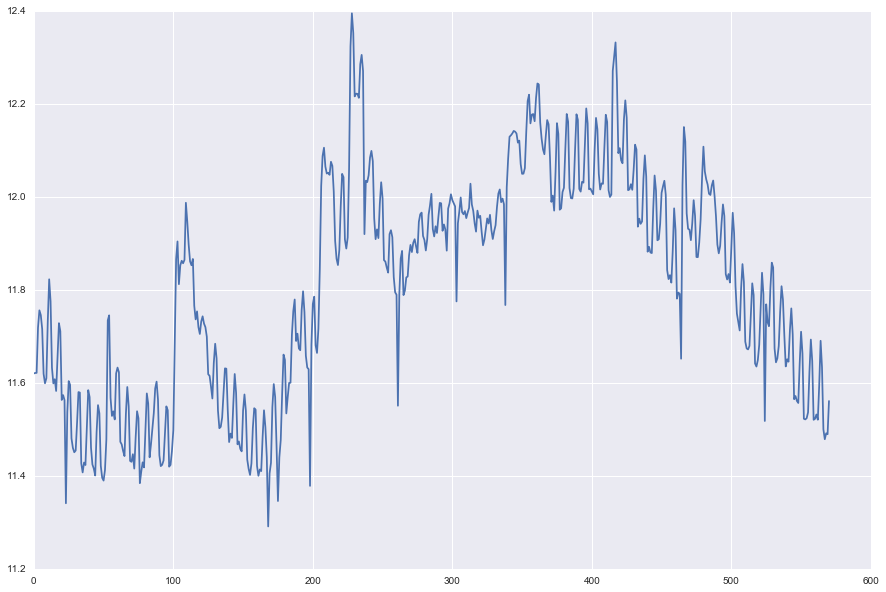

In [903]:
plt.plot(df.y);

In [904]:
m = Prophet(changepoint_prior_scale=0.02, holidays_prior_scale=0)
m.fit(df)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
596,2017-04-19,11.641847,11.548912,11.730195
597,2017-04-20,11.623913,11.535084,11.711491
598,2017-04-21,11.695369,11.607270,11.783531
599,2017-04-22,11.735267,11.638220,11.823533
600,2017-04-23,11.701380,11.607490,11.793936


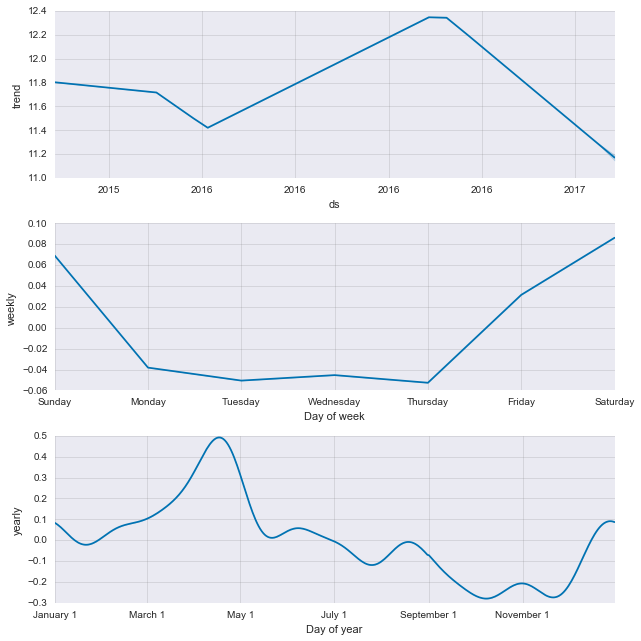

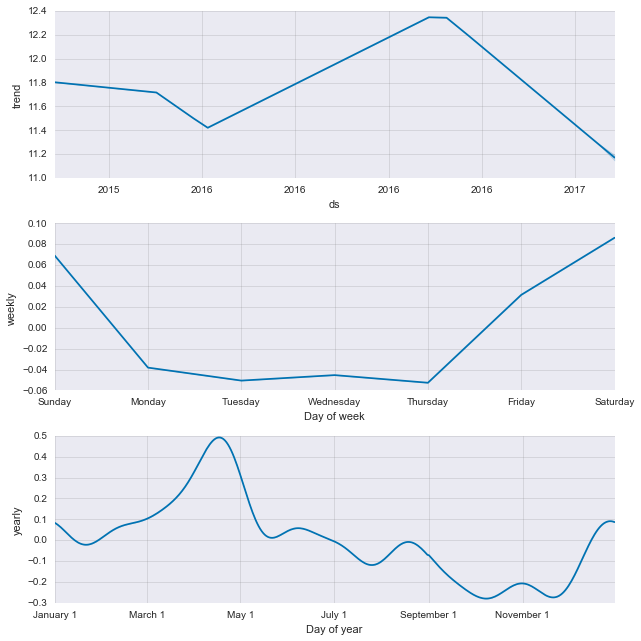

In [906]:
m.plot_components(forecast)

In [907]:
forecast["Anomalies"] = np.array([np.NaN]*len(forecast))
forecast.Anomalies[:-30][df.y<forecast.yhat_lower[:-30]] = df.y[df.y < forecast.yhat_lower[:-30]]

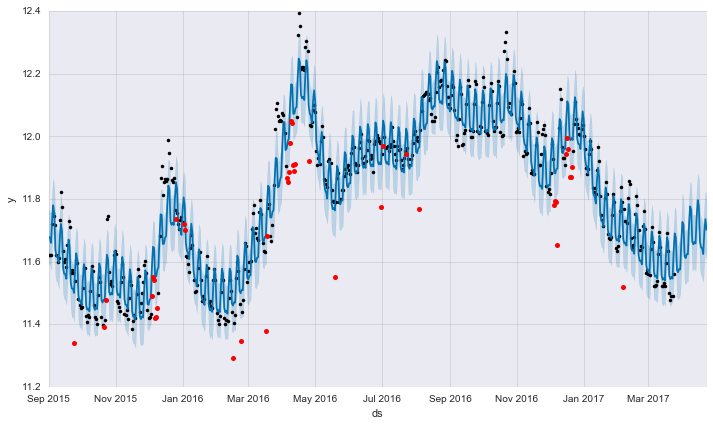

In [909]:
m.plot(forecast)
plt.plot(pd.Series(np.array(forecast.Anomalies), index=forecast.ds), "ro", markersize=5);